In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=3edfd9ebfda789714f4172ad9258f9ee5731f76a0b6548f56a35ad63f38e39a1
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=205fafd3e0f1fa7fe3a982411494719f9e0c1f903439c4706b786837cca44f7b
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-r59a1802
  Running command git clone --filter=blob:no

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 14.02 MiB/s, done.


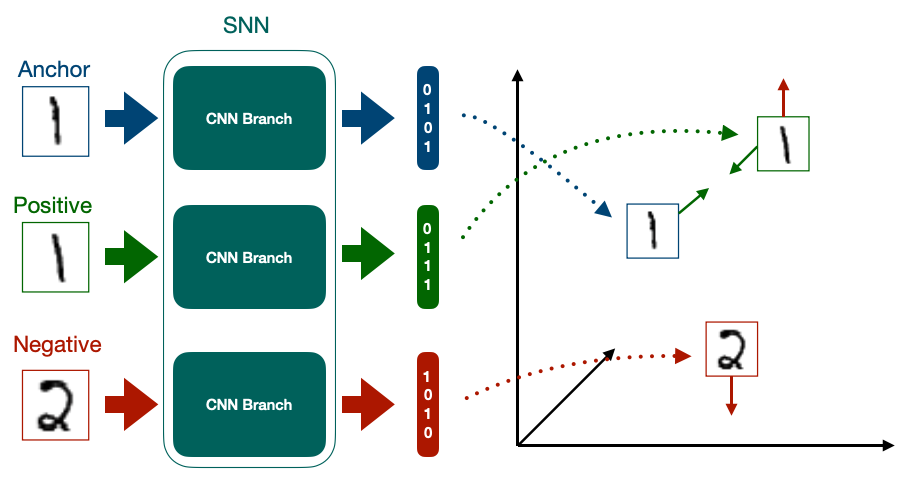

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

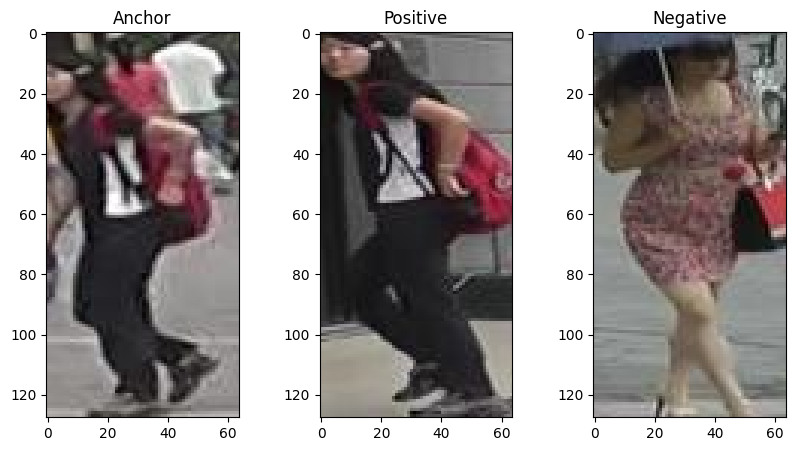

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


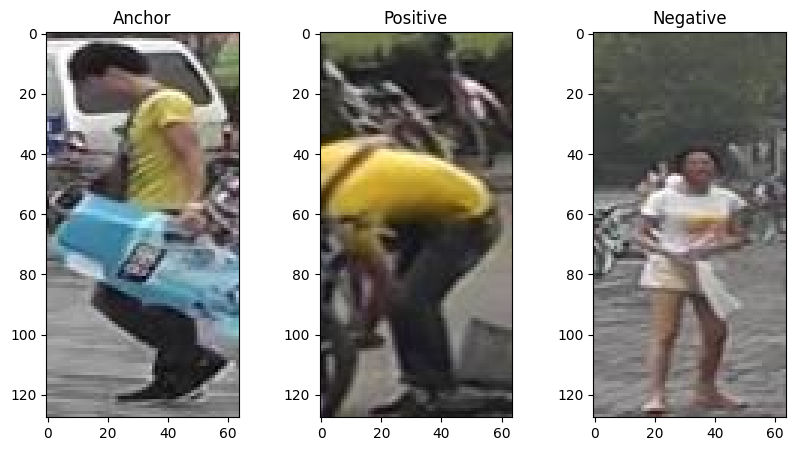

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
# Using data loader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
      super(APN_Model, self).__init__()

      self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
      self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,
                                               out_features = emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)

    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  # tqdm - to track the batches of dataloader
  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward() # Find gradients
    optimizer.step() # Update parameters

    total_loss += loss.item()

  return total_loss / len(dataloader) # Number of batches

In [ ]:
def eval_fn(model, dataloader, criterion):

  model.eval() # 0FF Dropout
  total_loss = 0.0

  # tqdm - to track the batches of dataloader
  with torch.set_grad_enabled(True):
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      loss.backward() # Find gradients

      total_loss += loss.item()

    return total_loss / len(dataloader) # Number of batches

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS : {i + 1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:04<00:00,  5.29it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.23097295813262464 valid_loss : 0.21908469945192338


100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.11521380566060543 valid_loss : 0.14741388827562332


100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 0.0878738584369421 valid_loss : 0.13638102352619172


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 0.058795059099793434 valid_loss : 0.10667463570833206


100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


EPOCHS : 5 train_loss : 0.05090457737445831 valid_loss : 0.17928750216960906


100%|██████████| 25/25 [00:05<00:00,  4.84it/s]


EPOCHS : 6 train_loss : 0.06632937982678414 valid_loss : 0.10856429100036621


100%|██████████| 25/25 [00:05<00:00,  4.70it/s]


EPOCHS : 7 train_loss : 0.039207923412323 valid_loss : 0.11287430614233017


100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 8 train_loss : 0.02361523050814867 valid_loss : 0.0726910299062729


100%|██████████| 25/25 [00:05<00:00,  4.69it/s]


EPOCHS : 9 train_loss : 0.012214015424251556 valid_loss : 0.07945959448814392


100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


EPOCHS : 10 train_loss : 0.03414957359433174 valid_loss : 0.14627281457185745


100%|██████████| 25/25 [00:05<00:00,  4.65it/s]


EPOCHS : 11 train_loss : 0.06687697753310204 valid_loss : 0.14600742131471633


100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


EPOCHS : 12 train_loss : 0.037597895115613934 valid_loss : 0.09587301403284072


100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


EPOCHS : 13 train_loss : 0.01932524725794792 valid_loss : 0.148999482691288


100%|██████████| 25/25 [00:05<00:00,  4.90it/s]


EPOCHS : 14 train_loss : 0.03926677323877811 valid_loss : 0.14973578363656997


100%|██████████| 25/25 [00:04<00:00,  5.02it/s]

EPOCHS : 15 train_loss : 0.016846976429224014 valid_loss : 0.11619135171175003


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.set_grad_enabled(True):
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

<ipython-input-33-fb78bba7c639>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████████| 4000/4000 [00:57<00:00, 

In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.422745,0.231334,0.620762,-0.018103,-0.323908,-0.392531,0.426465,0.933186,0.378689,...,-0.062071,0.048786,0.395910,-0.291366,0.796166,0.114143,0.137337,0.038735,0.227952,-0.568609
1,1420_c3s3_061978_03.jpg,0.499672,0.486154,0.960648,-0.145275,-0.433452,-0.295959,0.607023,1.120739,0.274702,...,0.118731,0.075188,0.725706,-0.454982,0.927920,0.109722,0.372379,0.150304,0.088337,-0.539106
2,1420_c5s3_062565_05.jpg,0.325318,0.258455,0.637095,-0.038717,-0.382463,-0.466116,0.514124,1.007368,0.309196,...,0.052558,0.066944,0.418133,-0.312689,0.802356,0.076981,0.123591,-0.012714,0.155637,-0.442422
3,1420_c6s3_085592_04.jpg,0.197565,0.285028,0.646357,-0.118027,-0.240773,-0.631397,0.676422,1.104190,0.233703,...,0.227315,-0.006700,0.476780,-0.321932,0.762729,0.153302,0.072773,-0.008241,0.293037,-0.291371
4,0663_c5s3_085987_03.jpg,0.188892,-0.419962,-0.197917,0.616243,-0.030796,-0.596944,-0.185255,-0.230730,0.306264,...,0.095482,-0.053476,-0.691154,0.290615,0.036492,0.300883,-0.616906,0.125914,0.700525,-0.146044


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.set_grad_enabled(True):
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i + 1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/layout.py:728: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


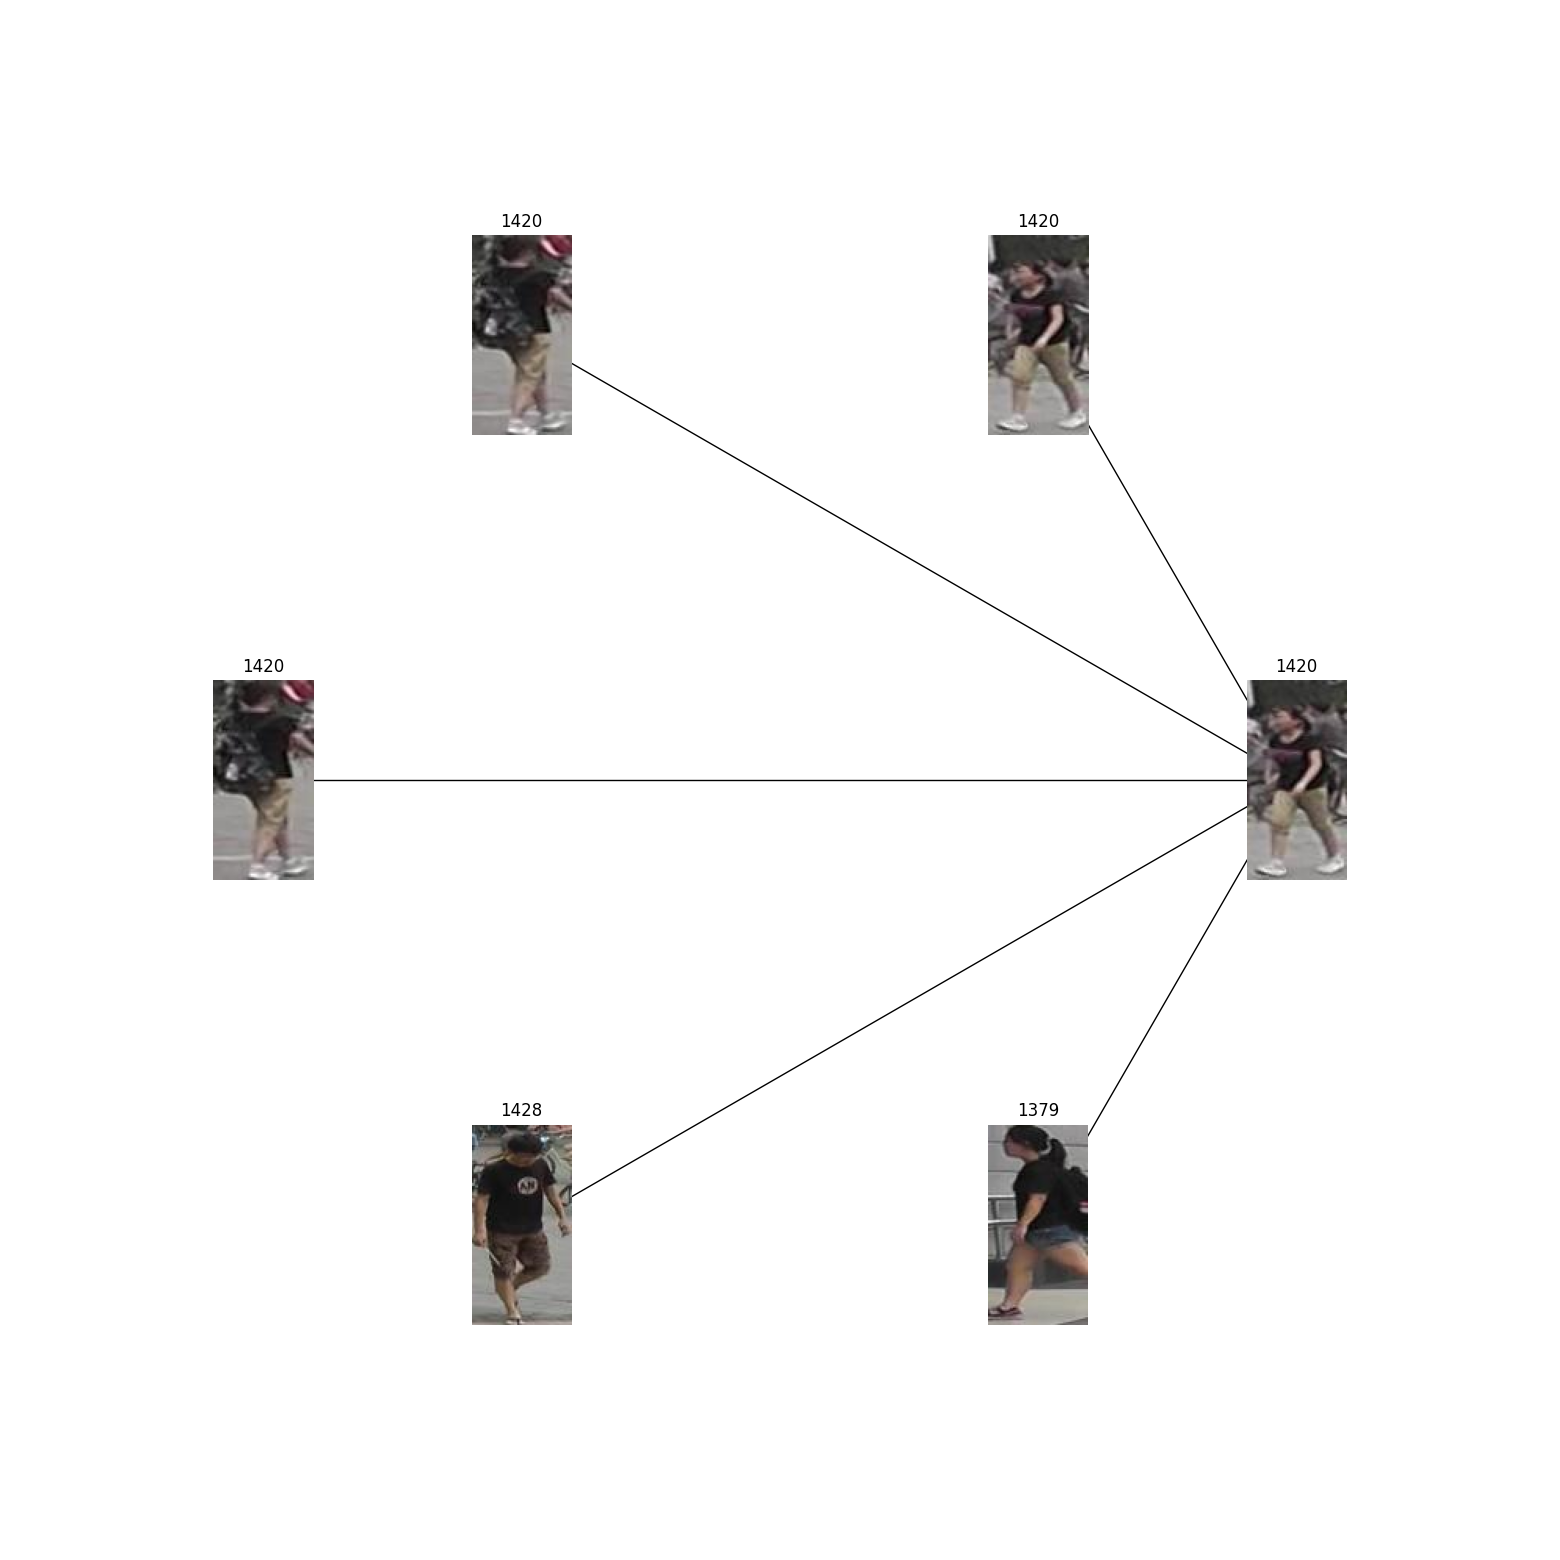

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);